In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from collections import Counter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA



import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import datetime as dt
import numpy as np
from datetime import datetime
import statsmodels.api as sm

### Carregando Dados

In [2]:
path = os.path.join('VendasTesouroDireto_1.json')
values = pd.read_json(path)
df_data = pd.DataFrame(values)
df_data['Tipo_Titulo'] = df_data['Tipo_Titulo'].astype('str') 
df_data['PU'] = df_data['PU'].str.replace(',', '.')
df_data['Quantidade'] = df_data['Quantidade'].str.replace(',', '.')
df_data['Valor'] = df_data['Valor'].str.replace(',', '.')
df_data['PU'] = pd.to_numeric(df_data['PU'], errors='coerce')
df_data['Quantidade'] = pd.to_numeric(df_data['Quantidade'], errors='coerce')
df_data['Valor'] = pd.to_numeric(df_data['Valor'], errors='coerce')
df_data['Vencimento_do_Titulo'] = pd.to_datetime(df_data['Vencimento_do_Titulo'])
df_data['Data_Venda'] = pd.to_datetime(df_data['Data_Venda'])


df_data

,Tipo_Titulo,Vencimento_do_Titulo,Data_Venda,PU,Quantidade,Valor
0,Tesouro IPCA+ com Juros Semestrais,2012-08-15,2008-05-12,1655.206735,38.6,63890.97
1,Tesouro IPCA+ com Juros Semestrais,2017-05-15,2008-05-12,1480.154343,571.0,845168.12
2,Tesouro Prefixado com Juros Semestrais,2014-01-01,2008-05-12,870.303177,283.2,246469.85
3,Tesouro Prefixado com Juros Semestrais,2012-01-01,2008-05-12,936.285273,29.2,27339.52
4,Tesouro Prefixado com Juros Semestrais,2017-01-01,2008-05-12,808.587250,491.8,397663.20
...,...,...,...,...,...,...
66164,Tesouro Prefixado com Juros Semestrais,2010-01-01,2008-08-27,960.339019,110.2,105829.35
66165,Tesouro IPCA+ com Juros Semestrais,2010-08-15,2008-08-27,1672.613421,271.2,453612.75
66166,Tesouro IPCA+ com Juros Semestrais,2011-05-15,2008-08-27,1677.517573,88.2,147957.04
66167,Tesouro Prefixado com Juros Semestrais,2010-01-07,2008-08-27,946.566666,0.6,567.93


### Visualizando, filtrando e organizando Dados

In [3]:
dftwo = df_data['Data_Venda'].value_counts().rename_axis('Data_Venda').reset_index(name='counts')
dftwo['Data_Venda'] = dftwo['Data_Venda'].astype(str)


x=dftwo['Data_Venda']
y=dftwo['counts']
plt.plot(x,y)
plt.plot()

[]

In [11]:
pu = df_data['Quantidade']
# será se deve ser essas colunas mesmo?
df_features = df_data.drop(columns=['Tipo_Titulo', 'Vencimento_do_Titulo', 'Data_Venda', 'Quantidade'])

df_features

,PU,Valor
0,1655.206735,63890.97
1,1480.154343,845168.12
2,870.303177,246469.85
3,936.285273,27339.52
4,808.587250,397663.20
...,...,...
66164,960.339019,105829.35
66165,1672.613421,453612.75
66166,1677.517573,147957.04
66167,946.566666,567.93


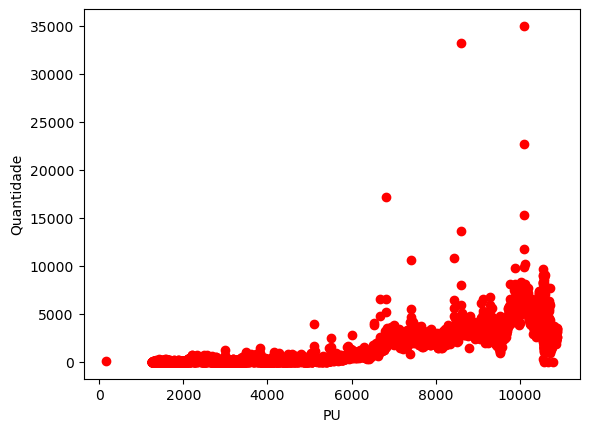

In [12]:
#df_datapu = [x for i, x  in enumerate(df_data['PU']) if i < 1000]
#df_dataqtd = [x for i, x  in enumerate(df_data['Quantidade']) if i < 1000]

#plt.scatter(df_datapu, df_dataqtd)
df_dados_c0=df_data[df_data['Tipo_Titulo']=='Tesouro Prefixado com Juros Semestrais']
df_dados_c1=df_data[df_data['Tipo_Titulo']=='Tesouro Selic']
df_dados_c2=df_data[df_data['Tipo_Titulo']=='Tesouro Prefixado']
df_dados_c3=df_data[df_data['Tipo_Titulo']=='Tesouro Prefixado IPCA+']
df_dados_c4=df_data[df_data['Tipo_Titulo']=='Tesouro IGPM+ com Juros Semestrais']
df_dados_c5=df_data[df_data['Tipo_Titulo']=='Tesouro Prefixado IPCA+ com Juros Semestrais']

#plt.scatter(df_dados_c0['PU'], df_dados_c0['Quantidade'],c='blue')
plt.scatter(df_dados_c1['PU'], df_dados_c1['Quantidade'],c='red')
#plt.scatter(df_dados_c2['PU'], df_dados_c2['Quantidade'],c='green')
#plt.scatter(df_dados_c3['PU'], df_dados_c3['Quantidade'],c='purple')
#plt.scatter(df_dados_c4['PU'], df_dados_c4['Quantidade'],c='yellow')
#plt.scatter(df_dados_c5['PU'], df_dados_c5['Quantidade'],c='red')


plt.xlabel('PU')
plt.ylabel('Quantidade')
# pode-se observar que quanto menor o preço unitário, maior é a quantidade vendida
plt.show()

In [13]:
df_features_c1=df_dados_c1.drop(columns=['Tipo_Titulo','Data_Venda','Vencimento_do_Titulo'])
df_features_c1_datas = df_dados_c1.drop(columns=['Tipo_Titulo','Vencimento_do_Titulo'])
df_features_c1

,PU,Quantidade,Valor
6,3694.700000,83.2,307399.04
9,3692.770059,133.6,493354.07
27,3728.658416,140.2,522757.90
32,3726.728894,39.8,148323.80
47,3730.540024,409.0,1525790.86
...,...,...,...
66128,3534.769820,100.4,354890.88
66138,3566.330371,75.4,268901.30
66144,3567.210000,76.0,271107.96
66162,3568.050000,175.4,625835.97


In [14]:
future_dates = df_features_c1_datas['Data_Venda']
first = min(df_features_c1_datas['Data_Venda'])
last = max(df_features_c1_datas['Data_Venda'])
diff = last - first
future_dates = future_dates + np.timedelta64(diff)
future_dates

6       2028-04-16
9       2028-04-16
27      2029-01-06
32      2029-01-06
47      2029-04-05
           ...    
66128   2028-07-04
66138   2028-07-31
66144   2028-07-31
66162   2028-08-01
66168   2028-08-01
Name: Data_Venda, Length: 7957, dtype: datetime64[ns]

In [15]:
# exemplo de filtro por intervalo de datas
def filter_interval (data_frame, min_dt, max_dt):
    min_date = np.datetime64(min_dt)
    max_date = np.datetime64(max_dt)
    filtered = [x for x in data_frame if x < max_date and x > min_date]
    return pd.DataFrame({'filtered': filtered})

def removable_indexes (data_frame, min_dt, max_dt):
    min_date = np.datetime64(min_dt)
    max_date = np.datetime64(max_dt)
    return [i for i, x in enumerate(data_frame) if x >= max_date or x <= min_date]

def remove_indexes (data_frame, indexes):
    return [x for i, x in enumerate(data_frame) if i not in indexes]

r = filter_interval(df_features_c1_datas['Data_Venda'], '2008-05-01', '2008-05-30')
r

,filtered
0,2008-05-12
1,2008-05-12
2,2008-05-11
3,2008-05-11
4,2008-05-23
5,2008-05-23
6,2008-05-09
7,2008-05-09
8,2008-05-06
9,2008-05-06


In [16]:
x1 = len(df_features_c1_datas['Data_Venda'])
x2 = len(df_features_c1['PU'])
if x1 != x2:
    raise Exception(f'{x1} is not equal to {x2}')

### Treinando modelo

In [17]:
def getModel():
    #return LinearRegression() # resultados menos efetivos, porém instantaneos e requer pouco processamento
    return RandomForestRegressor() # resultados melhores mas requer muito processamento

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_features.values, pu, test_size=0.2)
# pq está tão baixo?

model = getModel().fit(X_train, y_train)

score = model.score(X_test,y_test)

score

0.9971155371181294

In [19]:
#Tentando fazer o training com df_dados_c1(seriam os dados redimencionados para f1 e f2 dos tesouros de tipo Selic)
pu_selic=df_dados_c1['PU']
data_selic=df_dados_c1['Data_Venda']
X_train, X_test, y_train, y_test = train_test_split(df_features_c1.values, pu_selic, test_size=0.2)
model = getModel().fit(X_train, y_train)

score = model.score(X_test,y_test)

score

0.9999997508237665

In [ ]:
model.predict(X_train)

In [ ]:
pû_selic = cross_val_predict(getModel(),df_features_c1.values,  pu_selic, cv = 20)
datâ_selic = cross_val_predict(getModel(),df_features_c1.values,  data_selic, cv = 20)
datas = df_dados_c1['Data_Venda']
plt.scatter(datâ_selic, pû_selic)

plt.xlabel('Data Previsão')
plt.ylabel('PU Predito')

plt.show()

In [ ]:
plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')

plt.ylabel('PU')
plt.xlabel('Data Venda')
plt.show()
len(model.predict(X_train))

In [ ]:
min_date = '2008-06-01'
max_date = '2008-09-30'
filtered_sell_date = filter_interval(df_features_c1_datas['Data_Venda'], min_date, max_date)
pu_invalid_indexes = removable_indexes(df_features_c1_datas['Data_Venda'], min_date, max_date)
filtered_pu = pd.DataFrame({'PU': remove_indexes(df_features_c1['PU'], pu_invalid_indexes)})
#plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')
plt.scatter(filtered_sell_date, filtered_pu,c='red')

plt.ylabel('PU Real')
plt.xlabel('Data Venda Real')
plt.show()
len(model.predict(X_train))

In [ ]:
min_date = '2028-05-01'
max_date = '2028-08-10'
filtered_sell_date = filter_interval(future_dates, min_date, max_date)
pu_invalid_indexes = removable_indexes(future_dates, min_date, max_date)
filtered_pu = pd.DataFrame({'PU': remove_indexes(pû_selic, pu_invalid_indexes)})
#plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')
plt.scatter(filtered_sell_date, filtered_pu,c='red')

plt.ylabel('PU Previsão')
plt.xlabel('Data Venda Previsão')
plt.show()
len(model.predict(X_train))


In [ ]:
min_date = '2028-05-01'
max_date = '2029-05-01'
filtered_sell_date = filter_interval(future_dates, min_date, max_date)
pu_invalid_indexes = removable_indexes(future_dates, min_date, max_date)
filtered_pu = pd.DataFrame({'PU': remove_indexes(pû_selic, pu_invalid_indexes)})
#plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')
plt.scatter(filtered_sell_date, filtered_pu,c='red')

plt.ylabel('PU Previsão')
plt.xlabel('Data Venda Previsão')
plt.show()
len(model.predict(X_train))

In [ ]:
min_date = '2029-05-01'
max_date = '2030-05-01'
filtered_sell_date = filter_interval(future_dates, min_date, max_date)
pu_invalid_indexes = removable_indexes(future_dates, min_date, max_date)
filtered_pu = pd.DataFrame({'PU': remove_indexes(pû_selic, pu_invalid_indexes)})
#plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')
plt.scatter(filtered_sell_date, filtered_pu,c='red')

plt.ylabel('PU Previsão')
plt.xlabel('Data Venda Previsão')
plt.show()
len(model.predict(X_train))

In [ ]:
min_date = '2028-05-01'
max_date = '2035-05-01'
filtered_sell_date = filter_interval(future_dates, min_date, max_date)
pu_invalid_indexes = removable_indexes(future_dates, min_date, max_date)
filtered_pu = pd.DataFrame({'PU': remove_indexes(pû_selic, pu_invalid_indexes)})
#plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')
plt.scatter(filtered_sell_date, filtered_pu,c='red')

plt.ylabel('PU Previsão')
plt.xlabel('Data Venda Previsão')
plt.show()
len(model.predict(X_train))

In [ ]:
aux=df_data.drop(columns=['Tipo_Titulo','Vencimento_do_Titulo','PU'])
data_Value_Per_Month=pd.DataFrame(aux.groupby(aux['Data_Venda'].dt.to_period('m'))['Valor'].sum())
data_Value_Per_Month

### Validando dados

In [ ]:
scores = cross_val_score(getModel(), df_features.values, pu, cv = 10)
# pq está tão baixo?
print('R2=',np.mean(scores))

### Verificando correlação

In [ ]:
pû = cross_val_predict(getModel(), df_features.values, pu, cv = 20)
plt.scatter(pu, pû)

plt.xlabel('Real')
plt.ylabel('Predito')

plt.show()

In [ ]:
pû_selic

In [ ]:
fig=plt.figure(figsize=(10,3))
isSelic = df_data['Tipo_Titulo'] == "Tesouro Selic"
#if df_data.isSelic == true:
 #   plt.plot(df_data['PU'][isSelic],df_data['Quantidade'][isSelic])

plt.title('Line Plot')
plt.xlabel('Preço Unitário')
plt.ylabel('Quantidade')
#df_data['PU'][isSelic].value_counts()
plt.show()

isSelic

In [ ]:
#Aqui temos a serie
plt.xlabel('Meses')
plt.ylabel('Valor')
plt.title('Valor Total Mensal')

data_Value_Per_Month['Valor'].plot()

In [ ]:
aux=df_data.drop(columns=['Vencimento_do_Titulo','PU','Quantidade'])
aux.set_index('Data_Venda')
data_Value_Per_Month_Selic=pd.DataFrame(aux[aux['Tipo_Titulo']=='Tesouro Selic'].groupby(aux['Data_Venda'].dt.to_period('m'))['Valor'].sum())
data_Value_Per_Month_Selic

In [ ]:
plt.xlabel('Meses')
plt.ylabel('Valor')
plt.title('Valor Total Mensal(Selic)')

data_Value_Per_Month_Selic['Valor'].plot()

In [ ]:
data_Value_Per_Month.index=data_Value_Per_Month.index.to_timestamp()

In [ ]:
#Seasonal decompese nos da mais detalhes do comportamento da serie ao longo do tempos
result = seasonal_decompose(data_Value_Per_Month)
result.plot()
#Pode se ver que o dado e claramente afetado por estações,a trend esta agora apontando levemente para baixo

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_Value_Per_Month,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue



In [ ]:
#Pegamos a configuração que deu o menor AIC (Akaike Information Critera)
mod = sm.tsa.statespace.SARIMAX(data_Value_Per_Month,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
#Nesse grafico podemos ver prediçoes com o ARIMA
#No caso observando o nosso grafico o modelo começa a tentar preve a partir de janeiro de 2015 um mes a frente do real
pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = data_Value_Per_Month['2002':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Valor Total de Vendas')
plt.legend()
plt.show()

In [ ]:
#Aqui temos uma predição de 100 mese no futuro
#A areá cinza conta como uma margem de erro imagino
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = data_Value_Per_Month.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data')
ax.set_ylabel('Valor Total de Vendas')
plt.legend()
plt.show()
#Talves as vendas baixa antes de 2015 estejam enviezando?